In [3]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import XLNetTokenizer, XLNetModel,XLNetForSequenceClassification,AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import seaborn as sns
# from transformers import TFBertForSequenceClassification, BertTokenizer
import torch
import matplotlib.pyplot as plt


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Function to get the total number of lines in the file
def get_total_lines(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        return sum(1 for _ in file)

# Function to load rows where 'stars' feature is 1.0 or 2.0
def load_selected_data_0(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [1.0, 2.0]:  # Check for 1.0 or 2.0 stars
                data.append(row)
                count += 1
                if count == 100:  # Stop after collecting 5000 rows
                    break
    return data

# Function to load rows where 'stars' feature is 3.0
def load_selected_data_1(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') == 3.0:
                data.append(row)
                count += 1
                if count == 100:  # Stop after collecting 5000 rows
                    break
    return data

# Function to load rows where 'stars' feature is 4.0 or 5.0
def load_selected_data_2(filename):
    data = []
    count = 0
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = json.loads(line)
            if row.get('stars') in [4.0, 5.0]:  # Check for 4.0 or 5.0 stars
                data.append(row)
                count += 1
                if count == 100:  # Stop after collecting 5000 rows
                    break
    return data

# File path
file_path = 'D:\IIT\\3rd year\Deep learing\Cw model\yelp_dataset\yelp_academic_dataset_review.json'

# Load the data
yelp_data_0 = pd.DataFrame(load_selected_data_0(file_path))
yelp_data_1 = pd.DataFrame(load_selected_data_1(file_path))
yelp_data_2 = pd.DataFrame(load_selected_data_2(file_path))

In [8]:
yelp_data_0.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
2,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
3,Ki90-hauSIfW_7sBuBBqfA,Z2cOL3n9V8NoguJ-uU_Nvw,j8JOZvfeHEfUWq3gEz6ABQ,2.0,2,3,0,NEVER AGAIN. This is a so called restaurant th...,2014-06-11 14:55:14
4,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12


In [9]:
yelp_data_1.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
2,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
3,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06
4,ZVvhc3Go7v5I8XTiVoWmqQ,WBpQDAZymU0dhIqXcACGNw,ut6fi2W2YaipNOqvi7e0jw,3.0,0,0,0,"Upland is a brewery based out of Bloomington, ...",2014-11-12 14:12:20


In [10]:
yelp_data_2.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
2,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
3,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
4,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16


In [11]:
yelp_data = pd.concat([yelp_data_0, yelp_data_1, yelp_data_2])

# Resetting the index of the combined DataFrame
yelp_data.reset_index(drop=True, inplace=True)

# Displaying the first few rows of the combined DataFrame
yelp_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
1,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13
2,RB8UpF_kT2xoOC51OzXEeA,EZjT2qJN0mOXypMAqZdSrQ,A2q7d-CBM2-81tVkmS4JMw,2.0,1,1,0,"Straight to the point, it's cheap, it tastes a...",2017-07-08 18:58:42
3,Ki90-hauSIfW_7sBuBBqfA,Z2cOL3n9V8NoguJ-uU_Nvw,j8JOZvfeHEfUWq3gEz6ABQ,2.0,2,3,0,NEVER AGAIN. This is a so called restaurant th...,2014-06-11 14:55:14
4,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12


In [12]:
# Printing the shape
print("DataFrame Shape:", yelp_data.shape)

DataFrame Shape: (300, 9)


In [13]:
duplicates = yelp_data.duplicated()
print("Total duplicate rows:", duplicates.sum())

# Check for missing values
missing_values = yelp_data.isnull().sum()
print('\n',missing_values)

Total duplicate rows: 0

 review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [14]:
# Select the necessary features
yelp_data = yelp_data[['text']]

In [16]:

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetModel.from_pretrained('xlnet-base-cased')


In [17]:
model.to(device)

XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0-11): 12 x XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
def tokenize_data(yelp_data):
    input_ids = []
    attention_masks = []

    for index, row in yelp_data.iterrows():
        review = row['text']

        encoded_data = tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_data['input_ids'])
        attention_masks.append(encoded_data['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

train_input_ids, train_attention_masks = tokenize_data(yelp_data)

batch_size = 32

train_dataset = TensorDataset(train_input_ids, train_attention_masks)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)



In [19]:
# Model training
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = outputs.last_hidden_state.mean()  # can use a different reconstruction loss here

        total_loss += loss.item()

        loss.backward()
        optimizer.step()
    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {average_loss:.4f}')

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 10/10 [07:06<00:00, 42.70s/it]

Epoch 1 - Average Loss: -0.1524


In [20]:
torch.save(model, 'XLnet.pth')

In [21]:
model = torch.load('XLnet.pth')
model.to(device) 

XLNetModel(
  (word_embedding): Embedding(32000, 768)
  (layer): ModuleList(
    (0-11): 12 x XLNetLayer(
      (rel_attn): XLNetRelativeAttention(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): XLNetFeedForward(
        (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (layer_1): Linear(in_features=768, out_features=3072, bias=True)
        (layer_2): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (activation_function): GELUActivation()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(train_dataloader, desc='Generating Embeddings'):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)

# Apply Clustering (Example: K-Means)
num_clusters = 3  # You can adjust this based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Evaluate Clustering (Example: Silhouette Score)
silhouette_avg = silhouette_score(embeddings, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.4f}')

Generating Embeddings: 100%|██████████| 10/10 [01:22<00:00,  8.22s/it]
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.1044


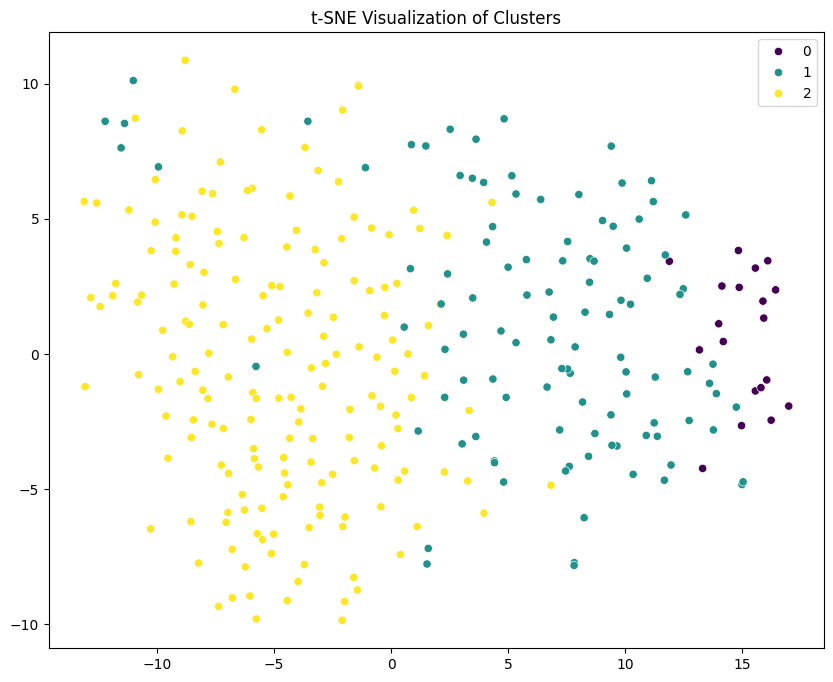

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize Clusters
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Clusters')
plt.show()

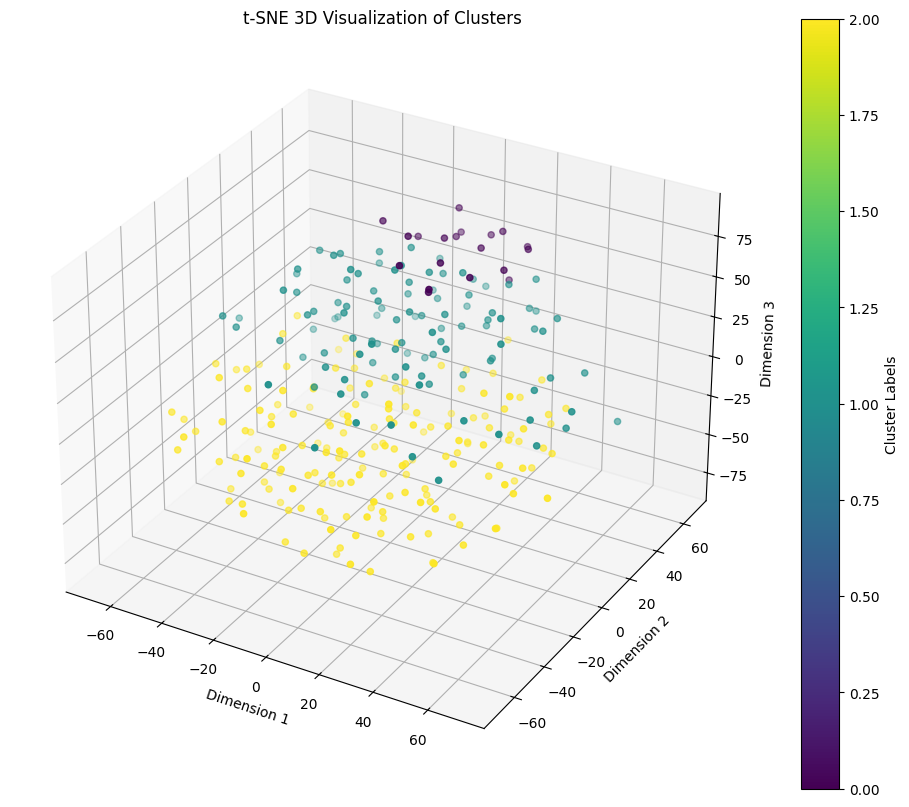

In [35]:
tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings)

# Visualize Clusters in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    embeddings_3d[:, 0],
    embeddings_3d[:, 1],
    embeddings_3d[:, 2],
    c=cluster_labels,
    cmap='viridis'
)

ax.set_title('t-SNE 3D Visualization of Clusters')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Cluster Labels')

plt.show()

In [36]:
def predict_text(input_text):
    model.eval()

    tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

    encoded_data = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    input_ids = encoded_data['input_ids'].to(device)
    attention_mask = encoded_data['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    cluster_label = kmeans.predict(embeddings.reshape(1, -1))[0]

    return cluster_label

# Example usage
new_text = "worst place ever"
predicted_cluster = predict_text(new_text)
print(f"Predicted Cluster: {predicted_cluster}")

Predicted Cluster: 0
